# Webscrape data


### Imports and functions

In [1]:
import pandas as pd
import os
from pathlib import Path
import time
import requests
from random import uniform
from bs4 import BeautifulSoup
import random
from fake_useragent import UserAgent
import unicodedata

def remove_special_characters(text):
    # Normalize the string to NFKD form
    normalized = unicodedata.normalize('NFKD', text)
    # Remove diacritics (non-spacing marks)
    without_special_chars = ''.join(c for c in normalized if not unicodedata.combining(c))
    return without_special_chars

### Naming convention for the tables

In [2]:
titles_12 = [
    'serie_A_overall',
    'serie_A_homeaway',
    'squad_standard_stats',
    'squad_standard_stats_opp',
    'squad_goalkeeping',
    'squad_goalkeeping_opp',
    'squad_advanced_goalkeeping',
    'squad_advanced_goalkeeping_opp',
    'squad_shooting',
    'squad_shooting_opp',
    'squad_passing',
    'squad_passing_opp',
    'squad_pass_types',
    'squad_pass_types_opp',
    'squad_goal_shot_creation',
    'squad_goal_shot_creation_opp',
    'squad_defensive_actions',
    'squad_defensive_actions_opp',
    'squad_possession',
    'squad_possession_opp',
    'squad_playing_time',
    'squad_playing_time_opp',
    'squad_miscellaneous',
    'squad_miscellaneous_opp',
]

titles_6 = titles_12[:6] + titles_12[8:10] + titles_12[20:]

titles_5 = titles_6[:6] + titles_6[8:]

### Acquire the league data

In [ ]:
os.makedirs('data/clubes/', exist_ok=True)
os.makedirs('data/league/', exist_ok=True)

In [ ]:
# Fetch all tables from the webpage
os.makedirs('data', exist_ok=True)
for page in range(11):
    
    url = f"https://fbref.com/en/comps/24/{2024 - page}/{2024 - page}-Serie-A-Stats"
    tables = pd.read_html(url)
    year = 2024 - page
    
    # Convert each table to a DataFrame
    if year > 2018:
        dfs = {f"{titles_12[i]}_{year}": table for i, table in enumerate(tables)}
    
    elif year > 2015:
        dfs = {f"{titles_6[i]}_{year}": table for i, table in enumerate(tables)}
    
    else:
        dfs = {f"{titles_5[i]}_{year}": table for i, table in enumerate(tables)}
    
    for name, df in dfs.items():
        df.to_csv(f"data/league/{name}.csv", index=False)


### Acquire player data

#### Get squads that were on Serie A and the year

In [1]:
## ID da página de acesso de cada clube
clubes = {
        'Botafogo-RJ': {'id': 'd9fdd9d9'},
        'Palmeiras': {'id': 'abdce579'},
        'Flamengo': {'id': '639950ae'},
        'Fortaleza': {'id': 'a9d0ab0e'},
        'Internacional': {'id': '6f7e1f03'},
        'Sao-Paulo': {'id': '5f232eb1'},
        'Corinthians': {'id': 'bf4acd28'},
        'Bahia': {'id': '157b7fee'},
        'Cruzeiro': {'id': '03ff5eeb'},
        'Vasco-da-Gama': {'id': '83f55dbe'},
        'Vitoria': {'id': '33f95fe0'},
        'Atletico-Mineiro': {'id': '422bb734'},
        'Fluminense': {'id': '84d9701c'},
        'Gremio': {'id': 'd5ae3703'},
        'Juventude': {'id': 'd081b697'},
        'RB-Bragantino': {'id': 'f98930d1'},
        'Ath-Paranaense': {'id': '2091c619'},
        'Criciuma': {'id': '3f7595bb'},
        'Atl-Goianiense': {'id': '32d508ca'},
        'Cuiaba': {'id': 'f0e6fb14'},
        'Santos': {'id': '712c528f'},
        'Goias': {'id': '78c617cc'},
        'Coritiba': {'id': 'd680d257'},
        'America-MG': {'id': '1f68d780'},
        'Ceara': {'id': '2f335e17'},
        'Avai': {'id': 'f205258a'},
        'Sport-Recife': {'id': 'ece66b78'},
        'Chapecoense': {'id': 'baa296ad'},
        'CSA': {'id': '05aff519'},
        'Parana': {'id': '2091c619'},
        'Ponte-Preta': {'id': 'b162ebe7'},
        'Figueirense': {'id': '0ce4436d'},
        'Santa-Cruz': {'id': 'ad0c1246'},
        'Joinville': {'id': 'da0666a2'},
    }
CLUBES = clubes.keys()

In [3]:
for clube in clubes:
    clubes[clube]['years_SA'] = []

In [4]:
# verifica se o time estava na serie A naquele ano e adiciona o ano na key 'years_SA'

for i in range(11):
    df = pd.read_csv(f'data/league/serie_A_overall_{2024 - i}.csv')

    unique_values = df['Squad'].unique()

    for value in unique_values:
        value = remove_special_characters(value.replace(" ", "-").replace("(", "").replace(")", ""))

        clubes[value]['years_SA'].append(2024 - i)
        

#### Scraping with pd.read_html()

In [ ]:
for clube, dados in clubes.items():
    # Create club directory if it doesn't exist
    club_dir = Path(f'data/clubes/{clube}')
    club_dir.mkdir(parents=True, exist_ok=True)
    
    for year in dados['years_SA']:
        # Generate expected filenames pattern for this year
        existing_files = list(club_dir.glob(f"{year}_*.csv"))
        
        # Skip if we already have files for this year
        if existing_files:
            print(f"Skipping {clube} {year} - already downloaded")
            continue
        
        url = f"https://fbref.com/en/squads/{clubes[clube]['id']}/{year}/{clube}-Stats"

        try:
            # Add delay to avoid 429 errors
            
            time.sleep(uniform(5, 30))
            tables = pd.read_html(url)
            
            # Save each table
            for i, table in enumerate(tables):
                filename = club_dir / f"{year}_{i}.csv"
                table.to_csv(filename, index=False)
            
            print(f"Saved {clube} {year}")
                
        except Exception as e:
            print(f"Failed to scrape {clube} {year}: {str(e)}")
            continue


Skipping Botafogo-RJ 2024 - already downloaded
Skipping Botafogo-RJ 2023 - already downloaded
Skipping Botafogo-RJ 2022 - already downloaded
Skipping Botafogo-RJ 2020 - already downloaded
Skipping Botafogo-RJ 2019 - already downloaded
Skipping Botafogo-RJ 2018 - already downloaded
Skipping Botafogo-RJ 2017 - already downloaded
Skipping Botafogo-RJ 2016 - already downloaded
Skipping Botafogo-RJ 2014 - already downloaded
Skipping Palmeiras 2024 - already downloaded
Skipping Palmeiras 2023 - already downloaded
Skipping Palmeiras 2022 - already downloaded
Skipping Palmeiras 2021 - already downloaded
Skipping Palmeiras 2020 - already downloaded
Skipping Palmeiras 2019 - already downloaded
Skipping Palmeiras 2018 - already downloaded
Skipping Palmeiras 2017 - already downloaded
Skipping Palmeiras 2016 - already downloaded
Skipping Palmeiras 2015 - already downloaded
Skipping Palmeiras 2014 - already downloaded
Skipping Flamengo 2024 - already downloaded
Skipping Flamengo 2023 - already downl

#### Rename the tables

In [17]:
title_clubes_13 = [
    'standard',
    'scores_fixtures',
    'goalkeeping',
    'advanced_goalkeeping',
    'shooting',
    'passing',
    'pass_types',
    'goal_shot_creation',
    'defesensive_actions',
    'possession',
    'playingtime',
    'miscellaneous',
    'serie_A_overall',
    'serie_A_homeaway',
]
title_clubes_7 = title_clubes_13[:3] + [title_clubes_13[4]] + title_clubes_13[10:]


In [ ]:
for clube, dados in clubes.items():
    
    club_dir = Path(f'data/clubes/{clube}')
    
    files = os.listdir(club_dir)
    
    for file in files:
       
        if file.split('_')[-1].split('.')[0].isdigit():
            
            year, digit = file.split('_')
            digit = digit.split('.')[0]

            if int(year) > 2018:
                new_name = f"{year}_{title_clubes_13[int(digit)]}.csv"
            else:
                new_name = f"{year}_{title_clubes_7[int(digit)]}.csv"


            os.rename(club_dir / file, club_dir / new_name)
            #print(club_dir / file, club_dir / new_name)




#### Test scraping

In [10]:
url = f"https://fbref.com/en/squads/d9fdd9d9/2022/Botafogo-RJ-Stats"
    

tables = pd.read_html(url)

# Save each table
for i, table in enumerate(tables):
    filename = f"data/clubes/Botafogo-RJ/{2022}_{i}.csv"
    table.to_csv(filename, index=False)

# Preprocessing

### Imports and functions

In [9]:
import pandas as pd
import os
from pathlib import Path

clubes = { # site id for each squad
        'Botafogo-RJ': {'id': 'd9fdd9d9'},
        'Palmeiras': {'id': 'abdce579'},
        'Flamengo': {'id': '639950ae'},
        'Fortaleza': {'id': 'a9d0ab0e'},
        'Internacional': {'id': '6f7e1f03'},
        'Sao-Paulo': {'id': '5f232eb1'},
        'Corinthians': {'id': 'bf4acd28'},
        'Bahia': {'id': '157b7fee'},
        'Cruzeiro': {'id': '03ff5eeb'},
        'Vasco-da-Gama': {'id': '83f55dbe'},
        'Vitoria': {'id': '33f95fe0'},
        'Atletico-Mineiro': {'id': '422bb734'},
        'Fluminense': {'id': '84d9701c'},
        'Gremio': {'id': 'd5ae3703'},
        'Juventude': {'id': 'd081b697'},
        'RB-Bragantino': {'id': 'f98930d1'},
        'Ath-Paranaense': {'id': '2091c619'},
        'Criciuma': {'id': '3f7595bb'},
        'Atl-Goianiense': {'id': '32d508ca'},
        'Cuiaba': {'id': 'f0e6fb14'},
        'Santos': {'id': '712c528f'},
        'Goias': {'id': '78c617cc'},
        'Coritiba': {'id': 'd680d257'},
        'America-MG': {'id': '1f68d780'},
        'Ceara': {'id': '2f335e17'},
        'Avai': {'id': 'f205258a'},
        'Sport-Recife': {'id': 'ece66b78'},
        'Chapecoense': {'id': 'baa296ad'},
        'CSA': {'id': '05aff519'},
        'Parana': {'id': '2091c619'},
        'Ponte-Preta': {'id': 'b162ebe7'},
        'Figueirense': {'id': '0ce4436d'},
        'Santa-Cruz': {'id': 'ad0c1246'},
        'Joinville': {'id': 'da0666a2'},
}

CLUBES = clubes.keys()

def process_names(df, multi_index=False, drop_matches = False):

    """
    Renames columns in the DataFrame based on their first row values,
    drops the first row, removes the 'Matches' column if it exists, 
    and resets the index.

    Parameters:
    df (pd.DataFrame): The input DataFrame to process.

    Returns:
    pd.DataFrame: The processed DataFrame with updated column names, 
                  the first row removed, and the index reset.
    """

    # Create rename dictionary first to avoid modifying DataFrame during iteration
    rename_dict = {}
    for col in df.columns:
        # Use .at[] for faster scalar value access
        first_row_value = df.at[0, col]
        
        if 'Unnamed' in col:
            # set the new column name depending on whether multi-index is True
            new_name = f"Info.{first_row_value}" if multi_index else first_row_value
        
        else:
            # set the new column name depending on whether multi-index is True
            prefix = col.split('.')[0]
            new_name = f"{prefix}.{first_row_value}" if multi_index else f"{prefix} {first_row_value}"
        
        rename_dict[col] = new_name

    # Apply all renames at once
    df = df.rename(columns=rename_dict)
    
    # Drop first row (index 0)
    df = df.drop(index=0)
    
    if drop_matches:
        # Set matches column name
        matches = 'Info.Matches' if multi_index else 'Matches'
        
        # Safely drop 'Matches' column if it exists
        if matches in df.columns:
            df = df.drop(columns=[matches])
    
    if multi_index:
        # set multi-index column names
        df.columns = pd.MultiIndex.from_tuples([tuple(col.split('.')) for col in df.columns])
    
    # Reset index and return the processed df
    return df.reset_index(drop=True)

def get_gringos(df, gringos, clube=None, year=None, nation=['br BRA']):

    """
    Filters the provided dataframe and returns only the players 
    that are not from the especified nationality(s).

    Parameters:
    df (pd.DataFrame): The input DataFrame to filter and process.
    gringos (pd.DataFrame): The existing DataFrame to append filtered rows to.
    clube (str, optional): Pass a name to add the squad name to the new df.
    nation (list): The nation(s) to be filtered out, default is 'br BRA'.

    Returns:
    pd.DataFrame: The updated `gringos` DataFrame with filtered rows 
                  appended and the optional 'Clube' and 'Year' columns added.
    """

    # Create a copy of the filtered data to avoid SettingWithCopyWarning
    new_gringos = df[~df['Nation'].isin(nation) & ~df['Nation'].isna()].copy()
    
    if clube:
        # Add column with squad names on position 5
        new_gringos.insert(loc=5, column='Clube', value=clube)
        #new_gringos['Clube'] = clube
    
    if year:
        # Add column with year on position 6
        new_gringos.insert(loc=6, column='Year', value=year)
        #new_gringos['Year'] = year

    if gringos.empty:
        gringos = new_gringos

    else:
        gringos = pd.concat([gringos, new_gringos], ignore_index=True)
    
    return gringos

def get_br(df, brasileiros, clube=None, year=None, nation=['br BRA']):

    # Create a copy of the filtered data to avoid SettingWithCopyWarning
    new_brasileiros = df[df['Nation'].isin(nation)].copy()
    
    if clube:
        # Add column with squad names on position 5
        new_brasileiros.insert(loc=5, column='Clube', value=clube)
        #new_gringos['Clube'] = clube
    
    if year:
        # Add column with year on position 6
        new_brasileiros.insert(loc=6, column='Year', value=year)
        #new_gringos['Year'] = year

    if brasileiros.empty:
        brasileiros = new_brasileiros

    else:
        brasileiros = pd.concat([brasileiros, new_brasileiros], ignore_index=True)
    
    return brasileiros



### Get foreigners from all datasets and save into .csv

In [12]:
gringos_df = pd.DataFrame()

for clube in CLUBES:
    
    club_dir = Path(f'data/clubes/{clube}')
    
    files = os.listdir(club_dir)
    
    for file in files:
        year = file.split('_')[0]
        if "standard" in file: #and year == '2024':
            temp_df = process_names(pd.read_csv(f'{club_dir}/{file}'))
            gringos_df = get_gringos(temp_df, gringos_df, clube=clube, year=year)

gringos_df = gringos_df.drop(columns='Matches')
gringos_df.to_csv('data/processed/gringos_df.csv', index=False)

In [13]:
gringos_df

Player  Nation    Pos   Age   MP        Clube  Year  \
0           Pablo Zeballos  py PAR  FW,MF  27.0   30  Botafogo-RJ  2014   
1            Mario Bolatti  ar ARG     MF  28.0   26  Botafogo-RJ  2014   
2            Emerson Sheik  qa QAT     FW  35.0   15  Botafogo-RJ  2014   
3     Luis Alberto Ramírez  pe PER  FW,MF  29.0   16  Botafogo-RJ  2014   
4     Juan Carlos Ferreyra  ar ARG     FW  30.0   10  Botafogo-RJ  2014   
...                    ...     ...    ...   ...  ...          ...   ...   
1015        Michael Ortega  co COL     MF  24.0  NaN  Figueirense  2016   
1016         Matías Pisano  ar ARG  FW,MF  24.0   11   Santa-Cruz  2016   
1017          Álex Bolaños  ec ECU     MF  31.0    3   Santa-Cruz  2016   
1018       Gutieri Tomelin  it ITA     DF  23.0   34    Joinville  2015   
1019       Mariano Trípodi  ar ARG     FW  27.0    3    Joinville  2015   

     Playing Time Starts Playing Time Min Playing Time 90s  ...  \
0                     22           1907.0             21.2  ...   
1                     19           1586.0             17.6  ...   
2                     15           1318.0             14.6  ...   
3                     14           1270.0             14.1  ...   
4                      6            569.0              6.3  ...   
...                  ...              ...              ...  ...   
1015                   0            142.0              1.6  ...   
1016                   8            575.0              6.4  ...   
1017                   2            113.0              1.3  ...   
1018                  33           2908.0             32.3  ...   
1019                   1            122.0              1.4  ...   

     Expected npxG+xAG Progression PrgC Progression PrgP Progression PrgR  \
0                  NaN              NaN              NaN              NaN   
1                  NaN              NaN              NaN              NaN   
2                  NaN              NaN              NaN              NaN   
3                  NaN              NaN              NaN              NaN   
4                  NaN              NaN              NaN              NaN   
...                ...              ...              ...              ...   
1015               NaN              NaN              NaN              NaN   
1016               NaN              NaN              NaN              NaN   
1017               NaN              NaN              NaN              NaN   
1018               NaN              NaN              NaN              NaN   
1019               NaN              NaN              NaN              NaN   

     Per 90 Minutes xG Per 90 Minutes xAG Per 90 Minutes xG+xAG  \
0                  NaN                NaN                   NaN   
1                  NaN                NaN                   NaN   
2                  NaN                NaN                   NaN   
3                  NaN                NaN                   NaN   
4                  NaN                NaN                   NaN   
...                ...                ...                   ...   
1015               NaN                NaN                   NaN   
1016               NaN                NaN                   NaN   
1017               NaN                NaN                   NaN   
1018               NaN                NaN                   NaN   
1019               NaN                NaN                   NaN   

     Per 90 Minutes npxG Per 90 Minutes npxG+xAG Playing Time MP  
0                    NaN                     NaN             NaN  
1                    NaN                     NaN             NaN  
2                    NaN                     NaN             NaN  
3                    NaN                     NaN             NaN  
4                    NaN                     NaN             NaN  
...                  ...                     ...             ...  
1015                 NaN                     NaN               7  
1016                 NaN                     NaN

### Get brasileiros

In [14]:
brasileiros_df = pd.DataFrame()

for clube in CLUBES:
    
    club_dir = Path(f'data/clubes/{clube}')
    
    files = os.listdir(club_dir)
    
    for file in files:
        year = file.split('_')[0]
        if "standard" in file: #and year == '2024':
            temp_df = process_names(pd.read_csv(f'{club_dir}/{file}'))
            brasileiros_df = get_br(temp_df, brasileiros_df, clube=clube, year=year)
brasileiros_df = brasileiros_df.drop(columns='Matches')
brasileiros_df.to_csv('data/processed/brasileiros_df.csv', index=False)

In [15]:
brasileiros_df

Player  Nation    Pos   Age  MP        Clube  Year  \
0          Gabriel  br BRA     MF  21.0  35  Botafogo-RJ  2014   
1     Júnior César  br BRA     DF  31.0  31  Botafogo-RJ  2014   
2        Jefferson  br BRA     GK  31.0  27  Botafogo-RJ  2014   
3      André Bahia  br BRA     DF  30.0  25  Botafogo-RJ  2014   
4          Bolívar  br BRA     DF  33.0  24  Botafogo-RJ  2014   
...            ...     ...    ...   ...  ..          ...   ...   
8535     Zé Arthur  br BRA     FW  18.0   0    Joinville  2015   
8536       Eusébio  br BRA  DF,MF  29.0   0    Joinville  2015   
8537  Bruno Furlan  br BRA     FW  22.0   0    Joinville  2015   
8538      Jhonatan  br BRA     GK  23.0   0    Joinville  2015   
8539      Jonathan  br BRA     MF  19.0   0    Joinville  2015   

     Playing Time Starts Playing Time Min Playing Time 90s  ...  \
0                     33           2993.0             33.3  ...   
1                     29           2569.0             28.5  ...   
2                     27           2430.0             27.0  ...   
3                     25           2250.0             25.0  ...   
4                     24           2160.0             24.0  ...   
...                  ...              ...              ...  ...   
8535                   0              NaN              NaN  ...   
8536                   0              NaN              NaN  ...   
8537                   0              NaN              NaN  ...   
8538                   0              NaN              NaN  ...   
8539                   0              NaN              NaN  ...   

     Expected npxG+xAG Progression PrgC Progression PrgP Progression PrgR  \
0                  NaN              NaN              NaN              NaN   
1                  NaN              NaN              NaN              NaN   
2                  NaN              NaN              NaN              NaN   
3                  NaN              NaN              NaN              NaN   
4                  NaN              NaN              NaN              NaN   
...                ...              ...              ...              ...   
8535               NaN              NaN              NaN              NaN   
8536               NaN              NaN              NaN              NaN   
8537               NaN              NaN              NaN              NaN   
8538               NaN              NaN              NaN              NaN   
8539               NaN              NaN              NaN              NaN   

     Per 90 Minutes xG Per 90 Minutes xAG Per 90 Minutes xG+xAG  \
0                  NaN                NaN                   NaN   
1                  NaN                NaN                   NaN   
2                  NaN                NaN                   NaN   
3                  NaN                NaN                   NaN   
4                  NaN                NaN                   NaN   
...                ...                ...                   ...   
8535               NaN                NaN                   NaN   
8536               NaN                NaN                   NaN   
8537               NaN                NaN                   NaN   
8538               NaN                NaN                   NaN   
8539               NaN                NaN                   NaN   

     Per 90 Minutes npxG Per 90 Minutes npxG+xAG Playing Time MP  
0                    NaN                     NaN             NaN  
1                    NaN                     NaN             NaN  
2                    NaN                     NaN             NaN  
3                    NaN                     NaN             NaN  
4                    NaN                     NaN             NaN  
...                  ...                     ...             ...  
8535                 NaN                     NaN             NaN  
8536                 NaN                     NaN             NaN  
8537                 NaN                     NaN             NaN  
8538          

# Analysis

## Load foreigner df

In [9]:
import pandas as pd

In [14]:
gringos = pd.read_csv('data/processed/gringos_df.csv')
brasileiros = pd.read_csv('data/processed/brasileiros_df.csv')

In [ ]:
brasileiros = brasileiros.drop(brasileiros[brasileiros['Pos'] == 'GK,MF'].index)
gringos = gringos.drop(gringos[gringos['Pos'] == 'GK, MF'].index)

In [22]:
metrics_bra_full = {}
metrics_gringos_full = {}

for year in brasileiros['Year'].unique():
    metrics_bra_full[year] = brasileiros[brasileiros['Year'] == year].describe()
    metrics_gringos_full[year] = gringos[gringos['Year'] == year].describe()

In [23]:
metrics_bra_by_pos = {}
metrics_gringos_by_pos = {}

for year in brasileiros['Year'].unique():
    metrics_bra_by_pos[year] = brasileiros[brasileiros['Year'] == year].groupby('Pos').describe()
    metrics_gringos_by_pos[year] = gringos[gringos['Year'] == year].groupby('Pos').describe()

## Create plot for all positions

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def extract_metric(source_dict, source_name, metric='mean'):
    """Extract mean values from a source dictionary."""
    df = pd.concat(
        {
            year: df.loc[metric].drop("Year", errors="ignore")
            for year, df in source_dict.items()
        },
        axis=1
    ).T.sort_index()
    df["Source"] = source_name 
    return df

In [ ]:
def plot_comparison_metrics(df1, df2, name1, name2, metric_plot, folder='full'):
    
     #Combine both datasets into a single DataFrame
    combined_means = pd.concat([
        extract_metric(df1, name1, metric=metric_plot),
        extract_metric(df2, name2, metric=metric_plot)
    ])

    # Pivot to have metrics as columns and sources as separate lines
    pivoted_df = combined_means.reset_index().melt(
        id_vars=["Source", "index"],  # "index" is the year
        var_name="Metric",
        value_name="Value"
    ).rename(columns={"index": "Year"})

    # Step 2: Generate comparative line plots
    # -----------------------------------------------------------------
    output_dir = f"data/comparison_plots/{folder}/{metric_plot}"
    os.makedirs(output_dir, exist_ok=True)


    for metric in combined_means.columns.drop("Source"):
        plt.figure(figsize=(10, 6))
        
        # Filter data for the current metric
        metric_data = pivoted_df[pivoted_df["Metric"] == metric]
        
        # Plot both sources
        for source_name, color, marker in [("Brasileiros", "blue", "o"), ("Estrangeiros", "red", "s")]:
            source_data = metric_data[metric_data["Source"] == source_name]
            plt.plot(
                source_data["Year"],
                source_data["Value"],
                marker=marker,
                linestyle="-",
                color=color,
                label=source_name
            )
        
        plt.title(f"Evolution of {metric} {metric_plot} Comparison")
        plt.xlabel("Year")
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        
        plt.savefig(os.path.join(output_dir, f"{metric}_{metric_plot}_comparison.png"), bbox_inches="tight")
        plt.close()

In [53]:
plot_comparison_metrics(metrics_bra_full, metrics_gringos_full, 'Brasileiros', 'Estrangeiros', 'mean')

In [54]:
plot_comparison_metrics(metrics_bra_full, metrics_gringos_full, 'Brasileiros', 'Estrangeiros', '50%')

In [55]:
plot_comparison_metrics(metrics_bra_full, metrics_gringos_full, 'Brasileiros', 'Estrangeiros', 'std')

## Create Plot for each position

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --------------------------------------------------------------
# 1. Clean Column Names & Combine Data
# --------------------------------------------------------------
def clean_column_name(col):
    """Convert MultiIndex tuples (e.g., ('Per 90 Minutes Ast', 'max') to 'Per_90_Minutes_Ast_max'."""
    if isinstance(col, tuple):
        # Replace spaces in each part and join with underscores
        #print(col)
        parts = [str(part).replace(" ", "_").strip() for part in col]
        cleaned = "_".join(parts).strip("_")
        return cleaned
    else:
        # Handle non-tuple columns (e.g., existing strings with spaces)
        #print(col)
        return str(col).replace(" ", "_").strip("_")

def process_source_data(data_dict: dict, source_name: str) -> pd.DataFrame:
    """Process yearly DataFrames into a combined DataFrame with cleaned columns."""
    processed_dfs = []
    
    for year, df in data_dict.items():
        # 1. Flatten MultiIndex columns
        df.columns = [clean_column_name(col) for col in df.columns]
        
        # 2. Reset index to make positions a column
        df = df.reset_index().rename(columns={"index": "Position"})
        
        # 3. Add metadata columns
        df["Year"] = year
        df["Source"] = source_name
        
        processed_dfs.append(df)
    
    return pd.concat(processed_dfs, ignore_index=True)

def plot_comparison_metrics_by_pos(df1, df2, name1, name2, metric_plot):
    # Process both datasets (original and new)
    combined = pd.concat([
        process_source_data(df1, name1),
        process_source_data(df2, name2)
    ])

    # Melt the DataFrame
    melted = pd.melt(
        combined,
        id_vars=["Pos", "Year", "Source"],  # Now valid columns!
        var_name="Metric",
        value_name="Value"
    )

    # Convert 'Year' to integer
    combined["Year"] = combined["Year"].astype(int)
    melted["Year"] = melted["Year"].astype(int)

    # --------------------------------------------------------------
    # 3. Generate Yearly Line Plots
    # --------------------------------------------------------------

    output_dir = f"data/comparison_plots/by_pos/{metric_plot}"
    os.makedirs(output_dir, exist_ok=True)

    key_metrics = [metric for metric in melted.Metric.unique() if metric_plot in metric] 

    for metric in key_metrics:
        metric_data = melted[melted["Metric"] == metric]

        # Create FacetGrid
        g = sns.FacetGrid(
            metric_data,
            col="Pos",
            col_wrap=3,
            height=4,
            aspect=1.5,
            sharey=False,
            sharex=True  # Ensure consistent x-axis across subplots
        )
        
        # Plot lines
        g.map_dataframe(
            sns.lineplot,
            x="Year",
            y="Value",
            hue="Source",
            palette={name1: "blue", name2: "red"},
            marker="o",
            linewidth=2
        )
        
        # Set x-axis ticks and labels for ALL subplots
        years = sorted(metric_data["Year"].unique())
        for ax in g.axes.flat:
            ax.set_xticks(years)
            ax.set_xticklabels(years, rotation=45)
            ax.margins(x=0.1)  # Add padding around x-axis limits
        
        # Adjust figure spacing (top, bottom, and vertical/horizontal gaps)
        plt.subplots_adjust(
            top=0.85,    # Increase top margin for suptitle
            bottom=0.15, # Increase bottom margin for x-labels
            hspace=0.4,  # Vertical spacing between subplots
            wspace=0.3   # Horizontal spacing between subplots
        )
        
        # Add title and legend
        g.fig.suptitle(
            f"Yearly Trend of {metric.replace('_', ' ')} by Position",
            y=0.95,      # Adjust title position to avoid overlapping
            fontsize=14
        )
        g.add_legend(title="Source", bbox_to_anchor=(1.05, 0.5), loc="center")
        
        # Save the plot
        plt.savefig(
            os.path.join(output_dir, f"{metric}_by_position.png"),
            bbox_inches="tight",
            dpi=300
        )
        plt.close()

In [ ]:
df1 = metrics_bra_by_pos.copy()
df2 = metrics_gringos_by_pos.copy()

In [26]:
plot_comparison_metrics_by_pos(df1, df2,'Brasileiros', 'Estrangeiros', metric_plot='mean')
plot_comparison_metrics_by_pos(df1, df2,'Brasileiros', 'Estrangeiros', metric_plot='50%')
plot_comparison_metrics_by_pos(df1, df2,'Brasileiros', 'Estrangeiros', metric_plot='std')

## Achados

### Descrição colunas Standard Stats (tabela com as nacionalidades)

- Playing Time
    - MP - Matches Played
    - Starts - Games started by player (in the initial team)
    - Min - minutes played
    - 90s - minutes played divided by 90 (full matches played)
- Performance
    - Gls - Goals
    - Ast - Assists
    - G + A - Goals + Assists
    - G - PK - Non penalty goals
    - PK - Penalty Kicks Made
    - PKatt - Penalty Kicks Attempted
    - CrdY - Yellow Cards
    - CrdR - Red Cards
- Expected
    - xG - Expected Goals (includes PK but not penalty shootouts)
    - npxG - Non-penalty expected goals
    - xAG - Expected Assisted Goals
    - npxG + xAG
- Progression
    - PrgC - Progressive Carries, carreis that move the ball towards the oppent goal line at least 10 yeards
    - PrgP - Progressive Passes, completed passes that move the ball ...
    - PrgR - Progressive Passes Received, completed passes ...
- Per 90 Minutes
    

### Pergunta 1: Existe uma disparidade de desempenho entre jogadores de nacionalidade brasileira e dos estrangeiros? Quais aspectos influenciam?

Para responder esta pergunta iremos utilizar a tabela Standard Stats de cada clube no período de 2014 a 2024. Nela encontramos estatísticas de cada jogador, incluindo sua nacionalidade. A partir dos dados coletados criamos duas tabelas para fazer nossa análise: uma com os dados de jogadores brasileiros e outra com os dados de jogadores estrangeiros. A partir dessas tabelas calculamos a média, mediana e desvio padrão de cada estatística. Para o propósito desta entrega iremos focar nos resultados utilizando a média. Agrupamos os dados pela posição (Atacante, Goleiro, Lateral, etc.) e plotamos os valores médios para cada ano no período analisado. Abaixo seguem os gráficos das métricas: Performance_Gls (Gols marcados), Performance_Ast (Assistências), Progressive_PrgP (Passes completados em direção ao gol adversário), Play_Time_Min (Minutos Jogados).

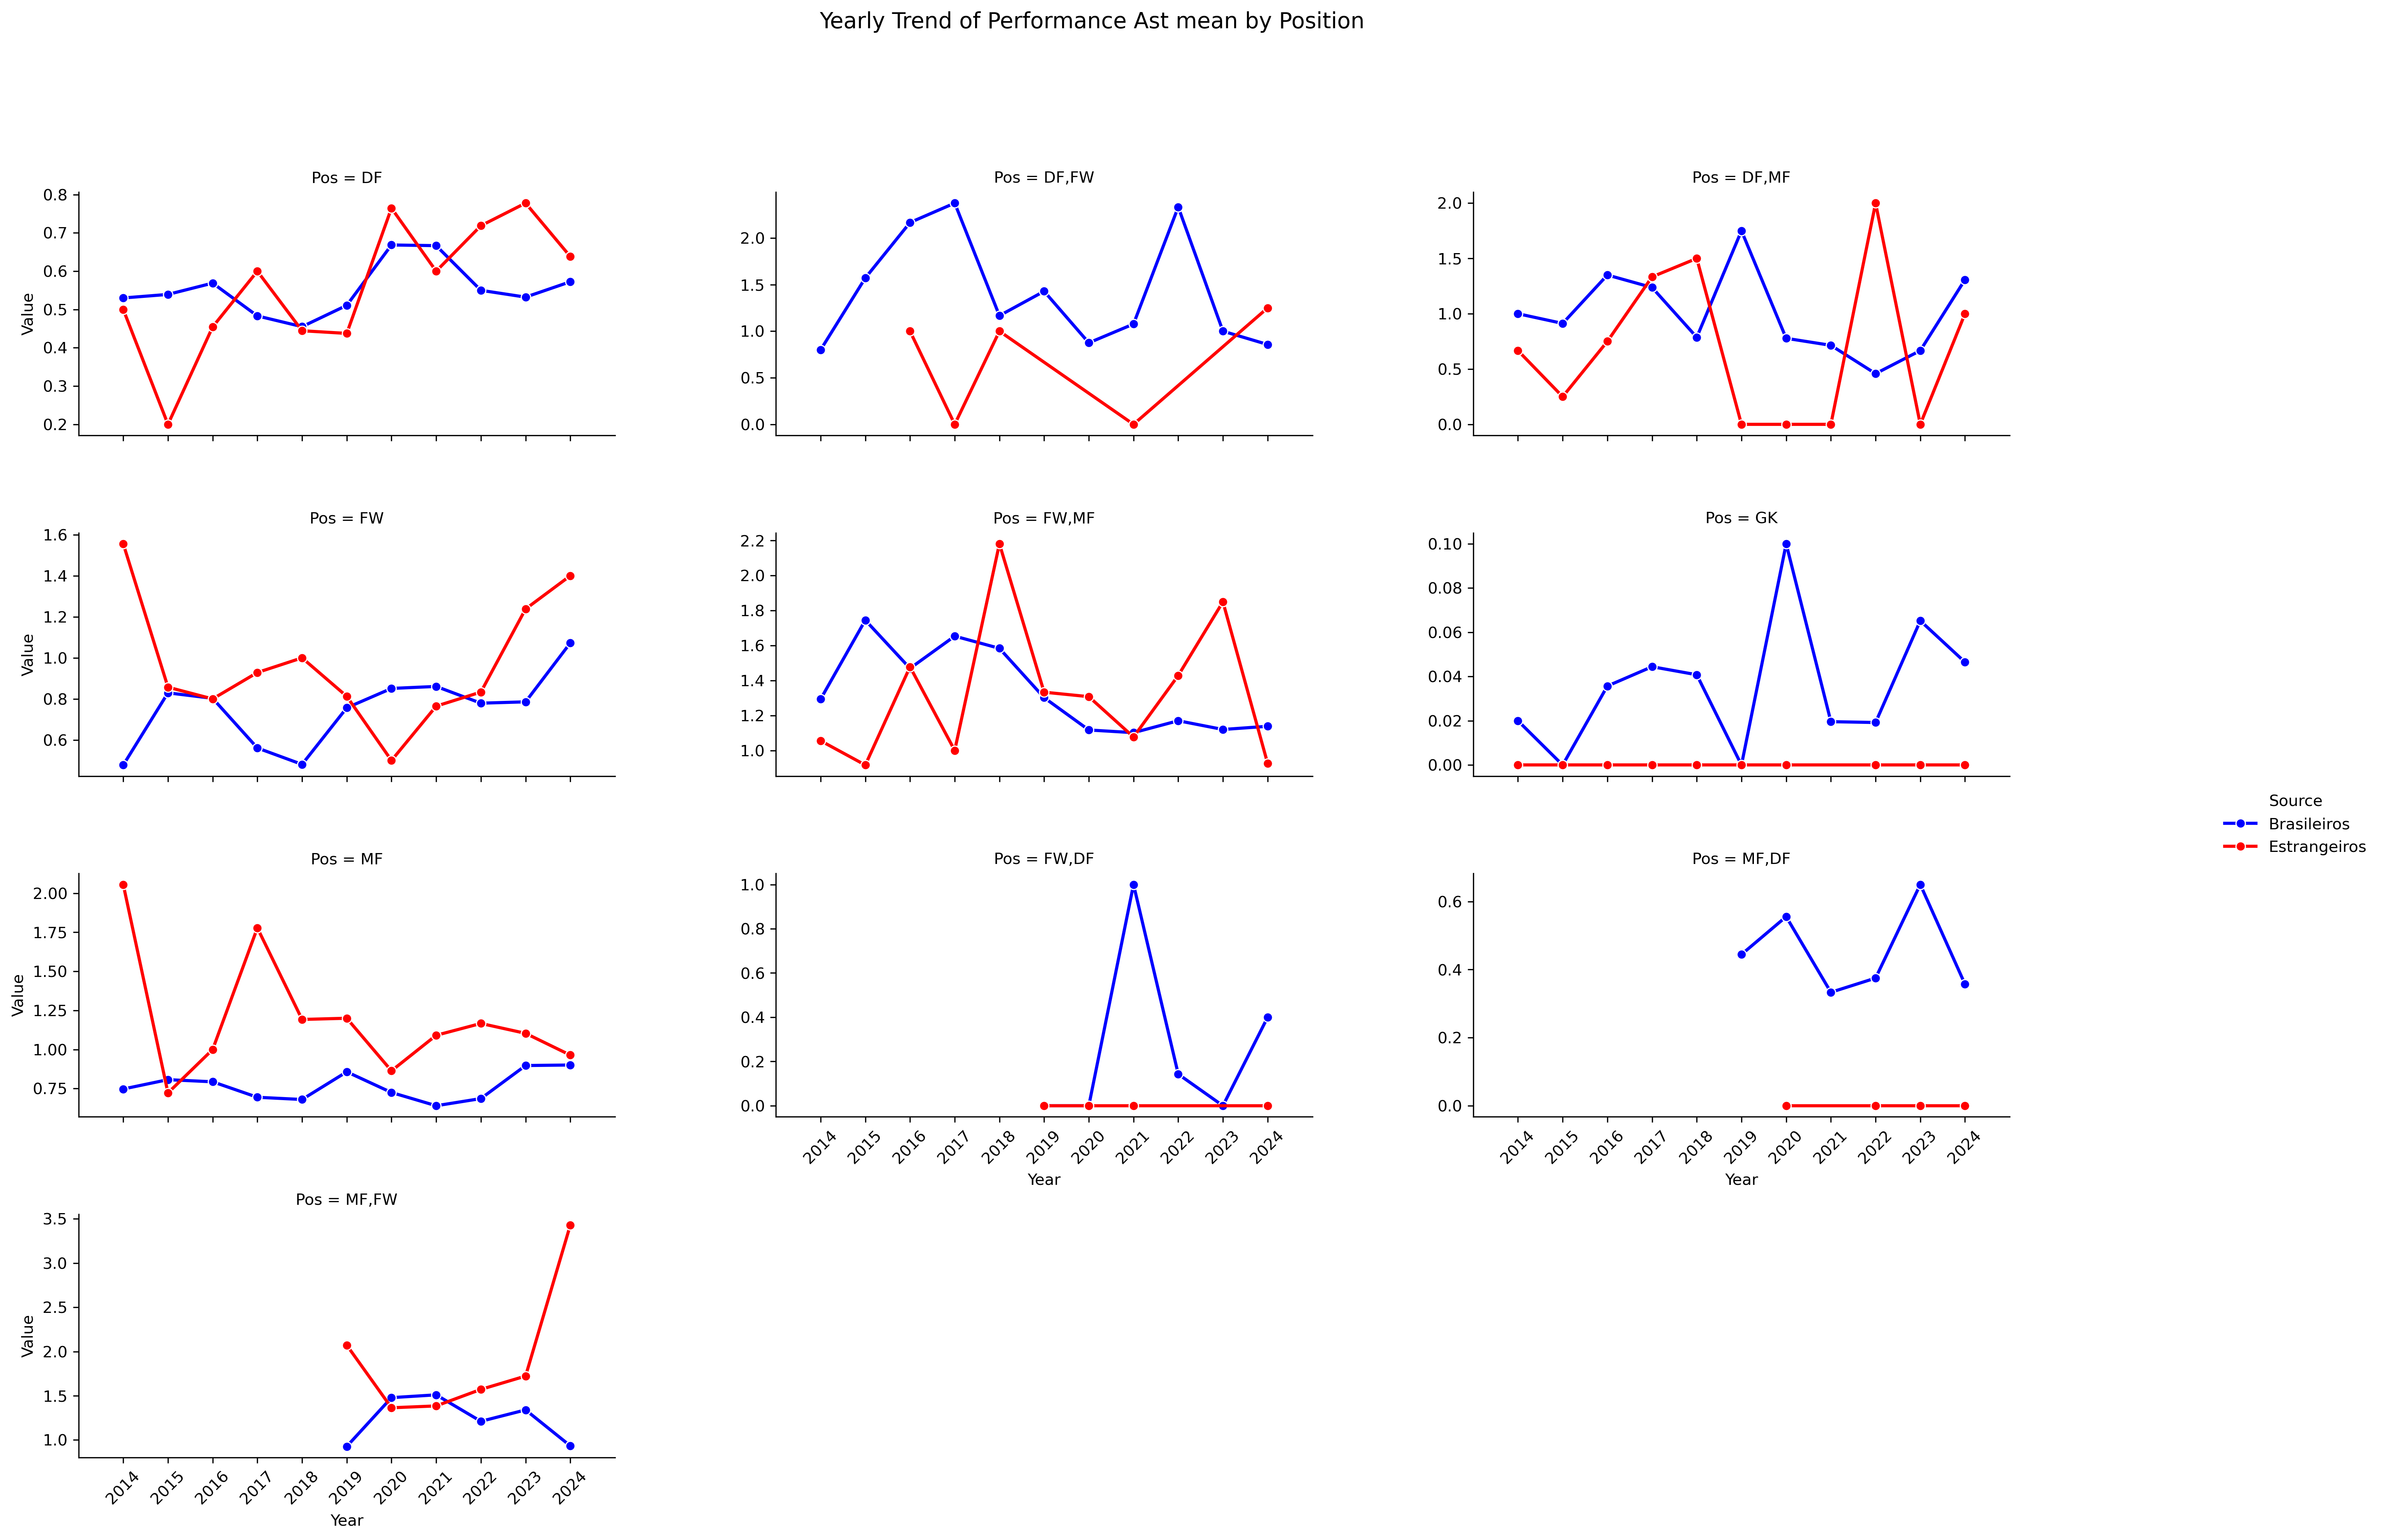

In [ ]:
from IPython.display import Image

Image("data/comparison_plots/by_pos/mean/Performance_Ast_mean_by_position.png")

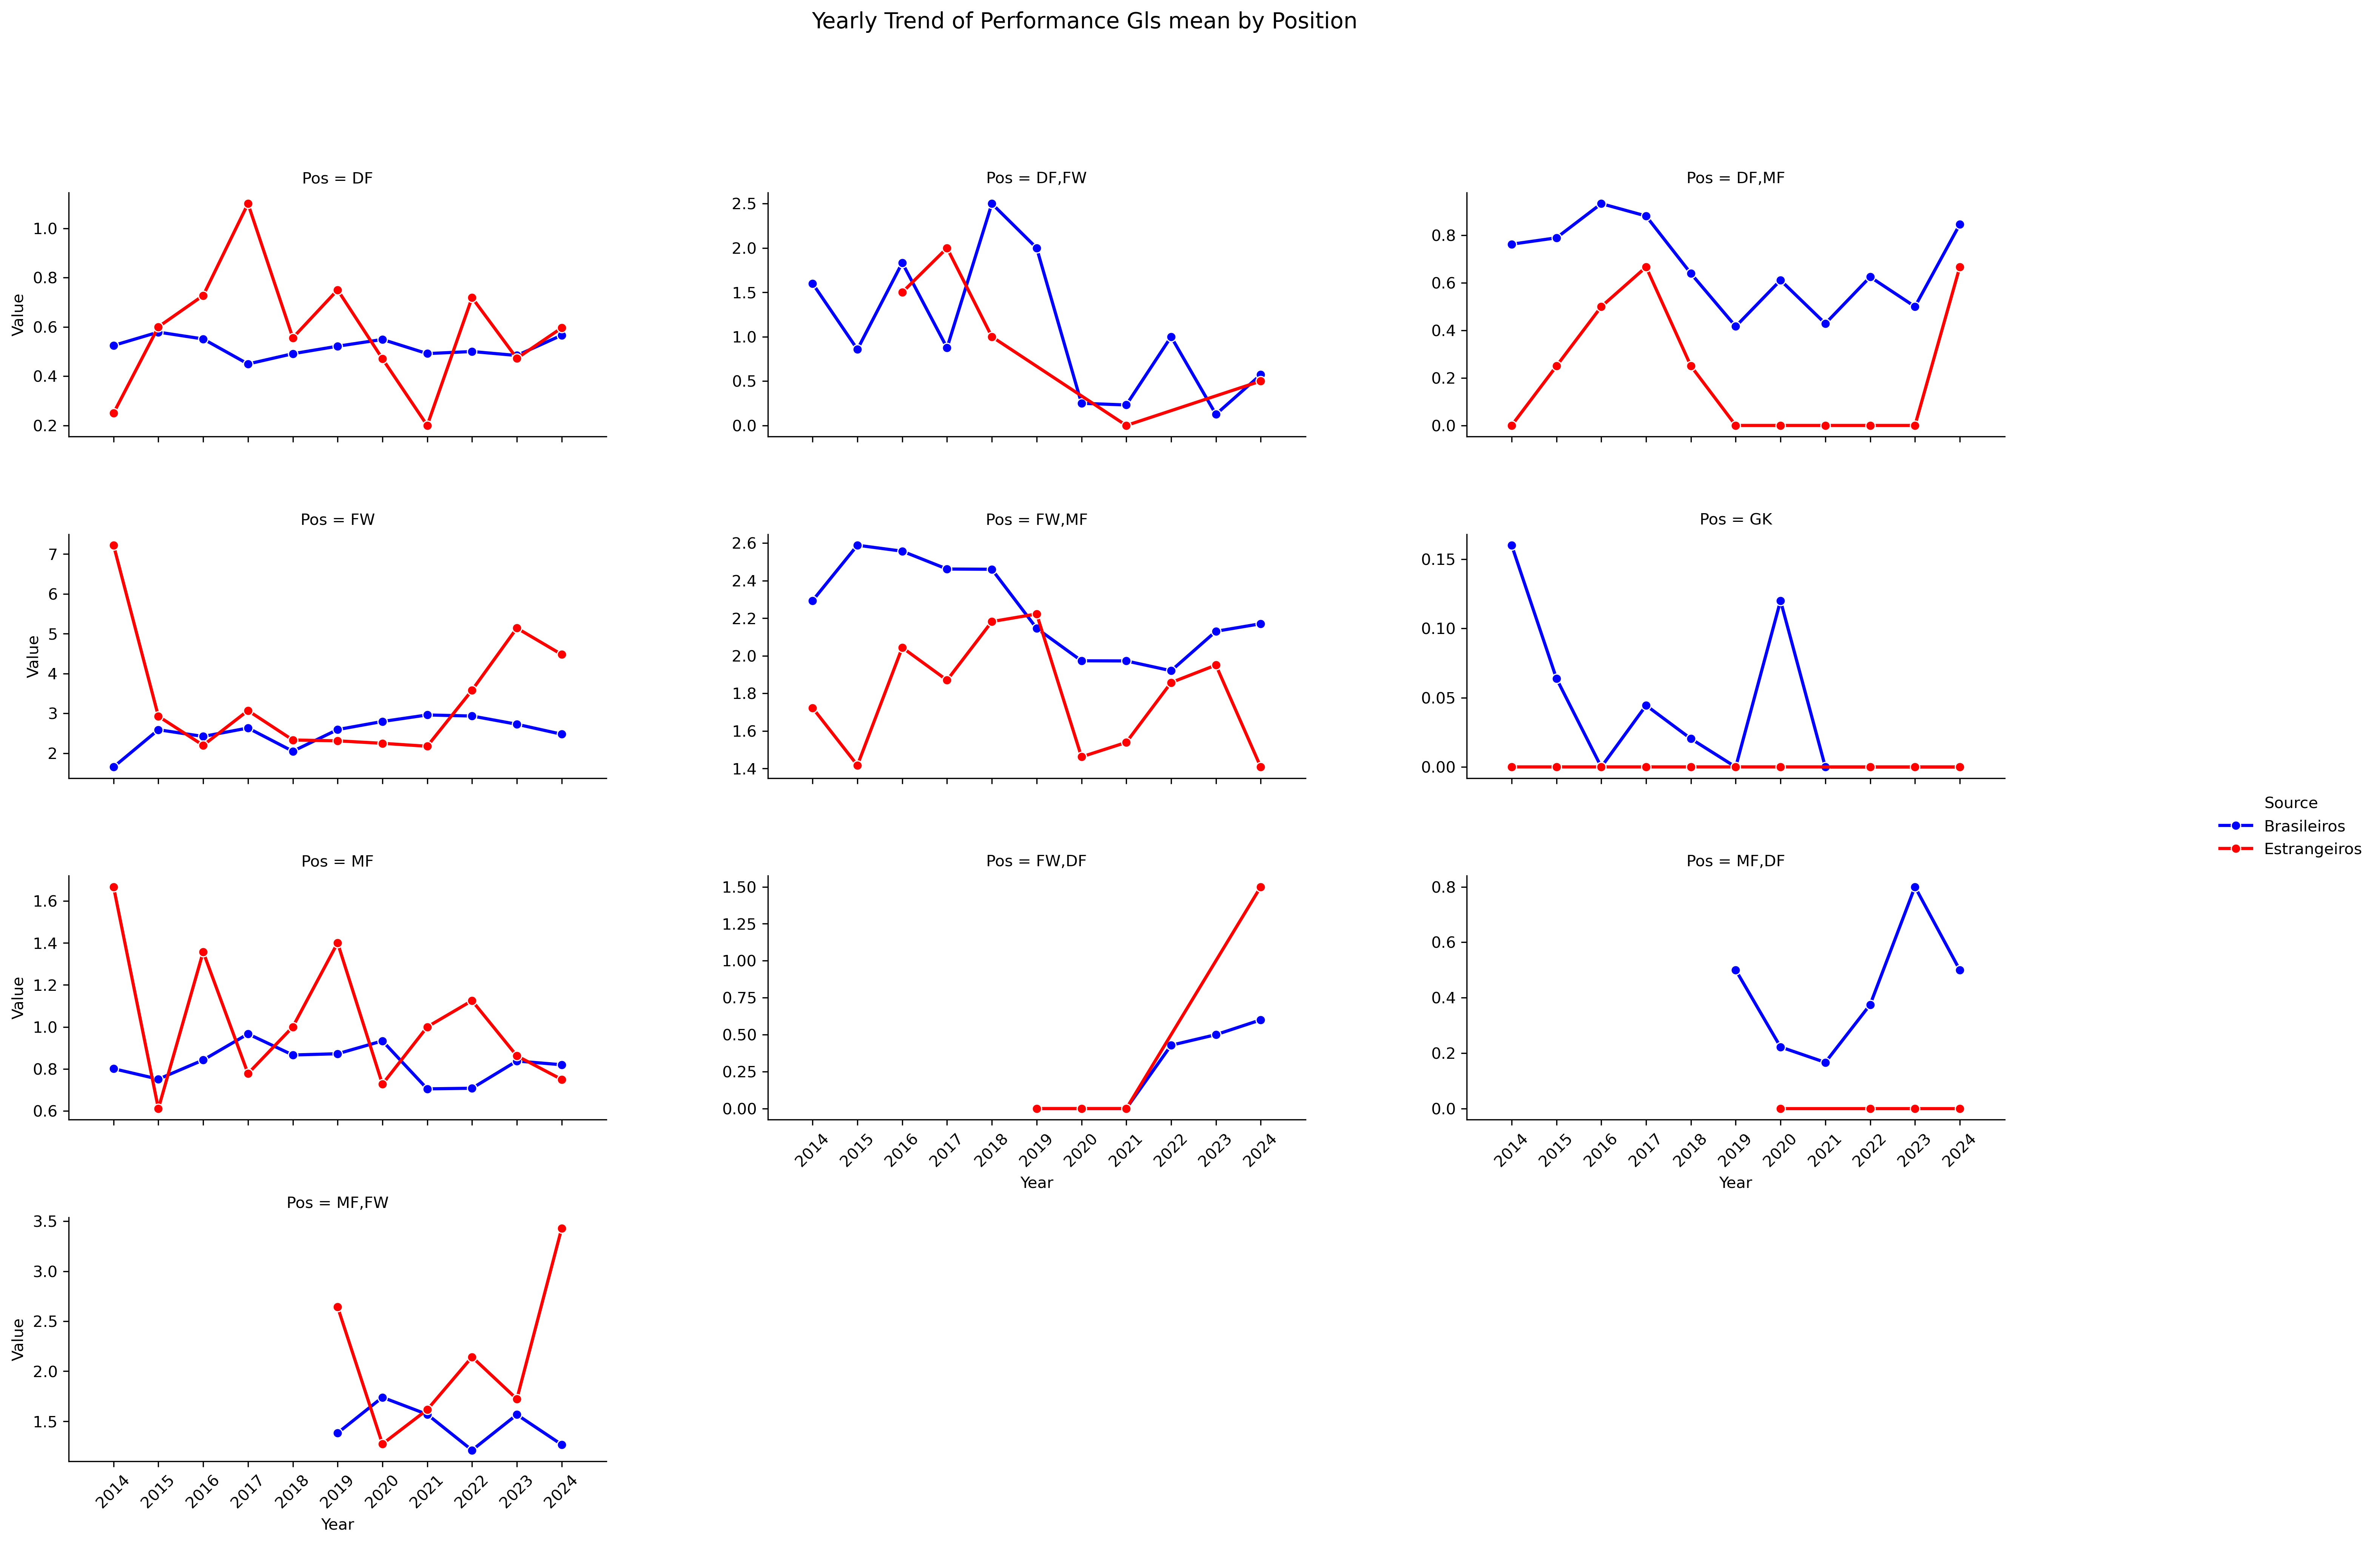

In [ ]:
Image("data/comparison_plots/by_pos/mean/Performance_Gls_mean_by_position.png")

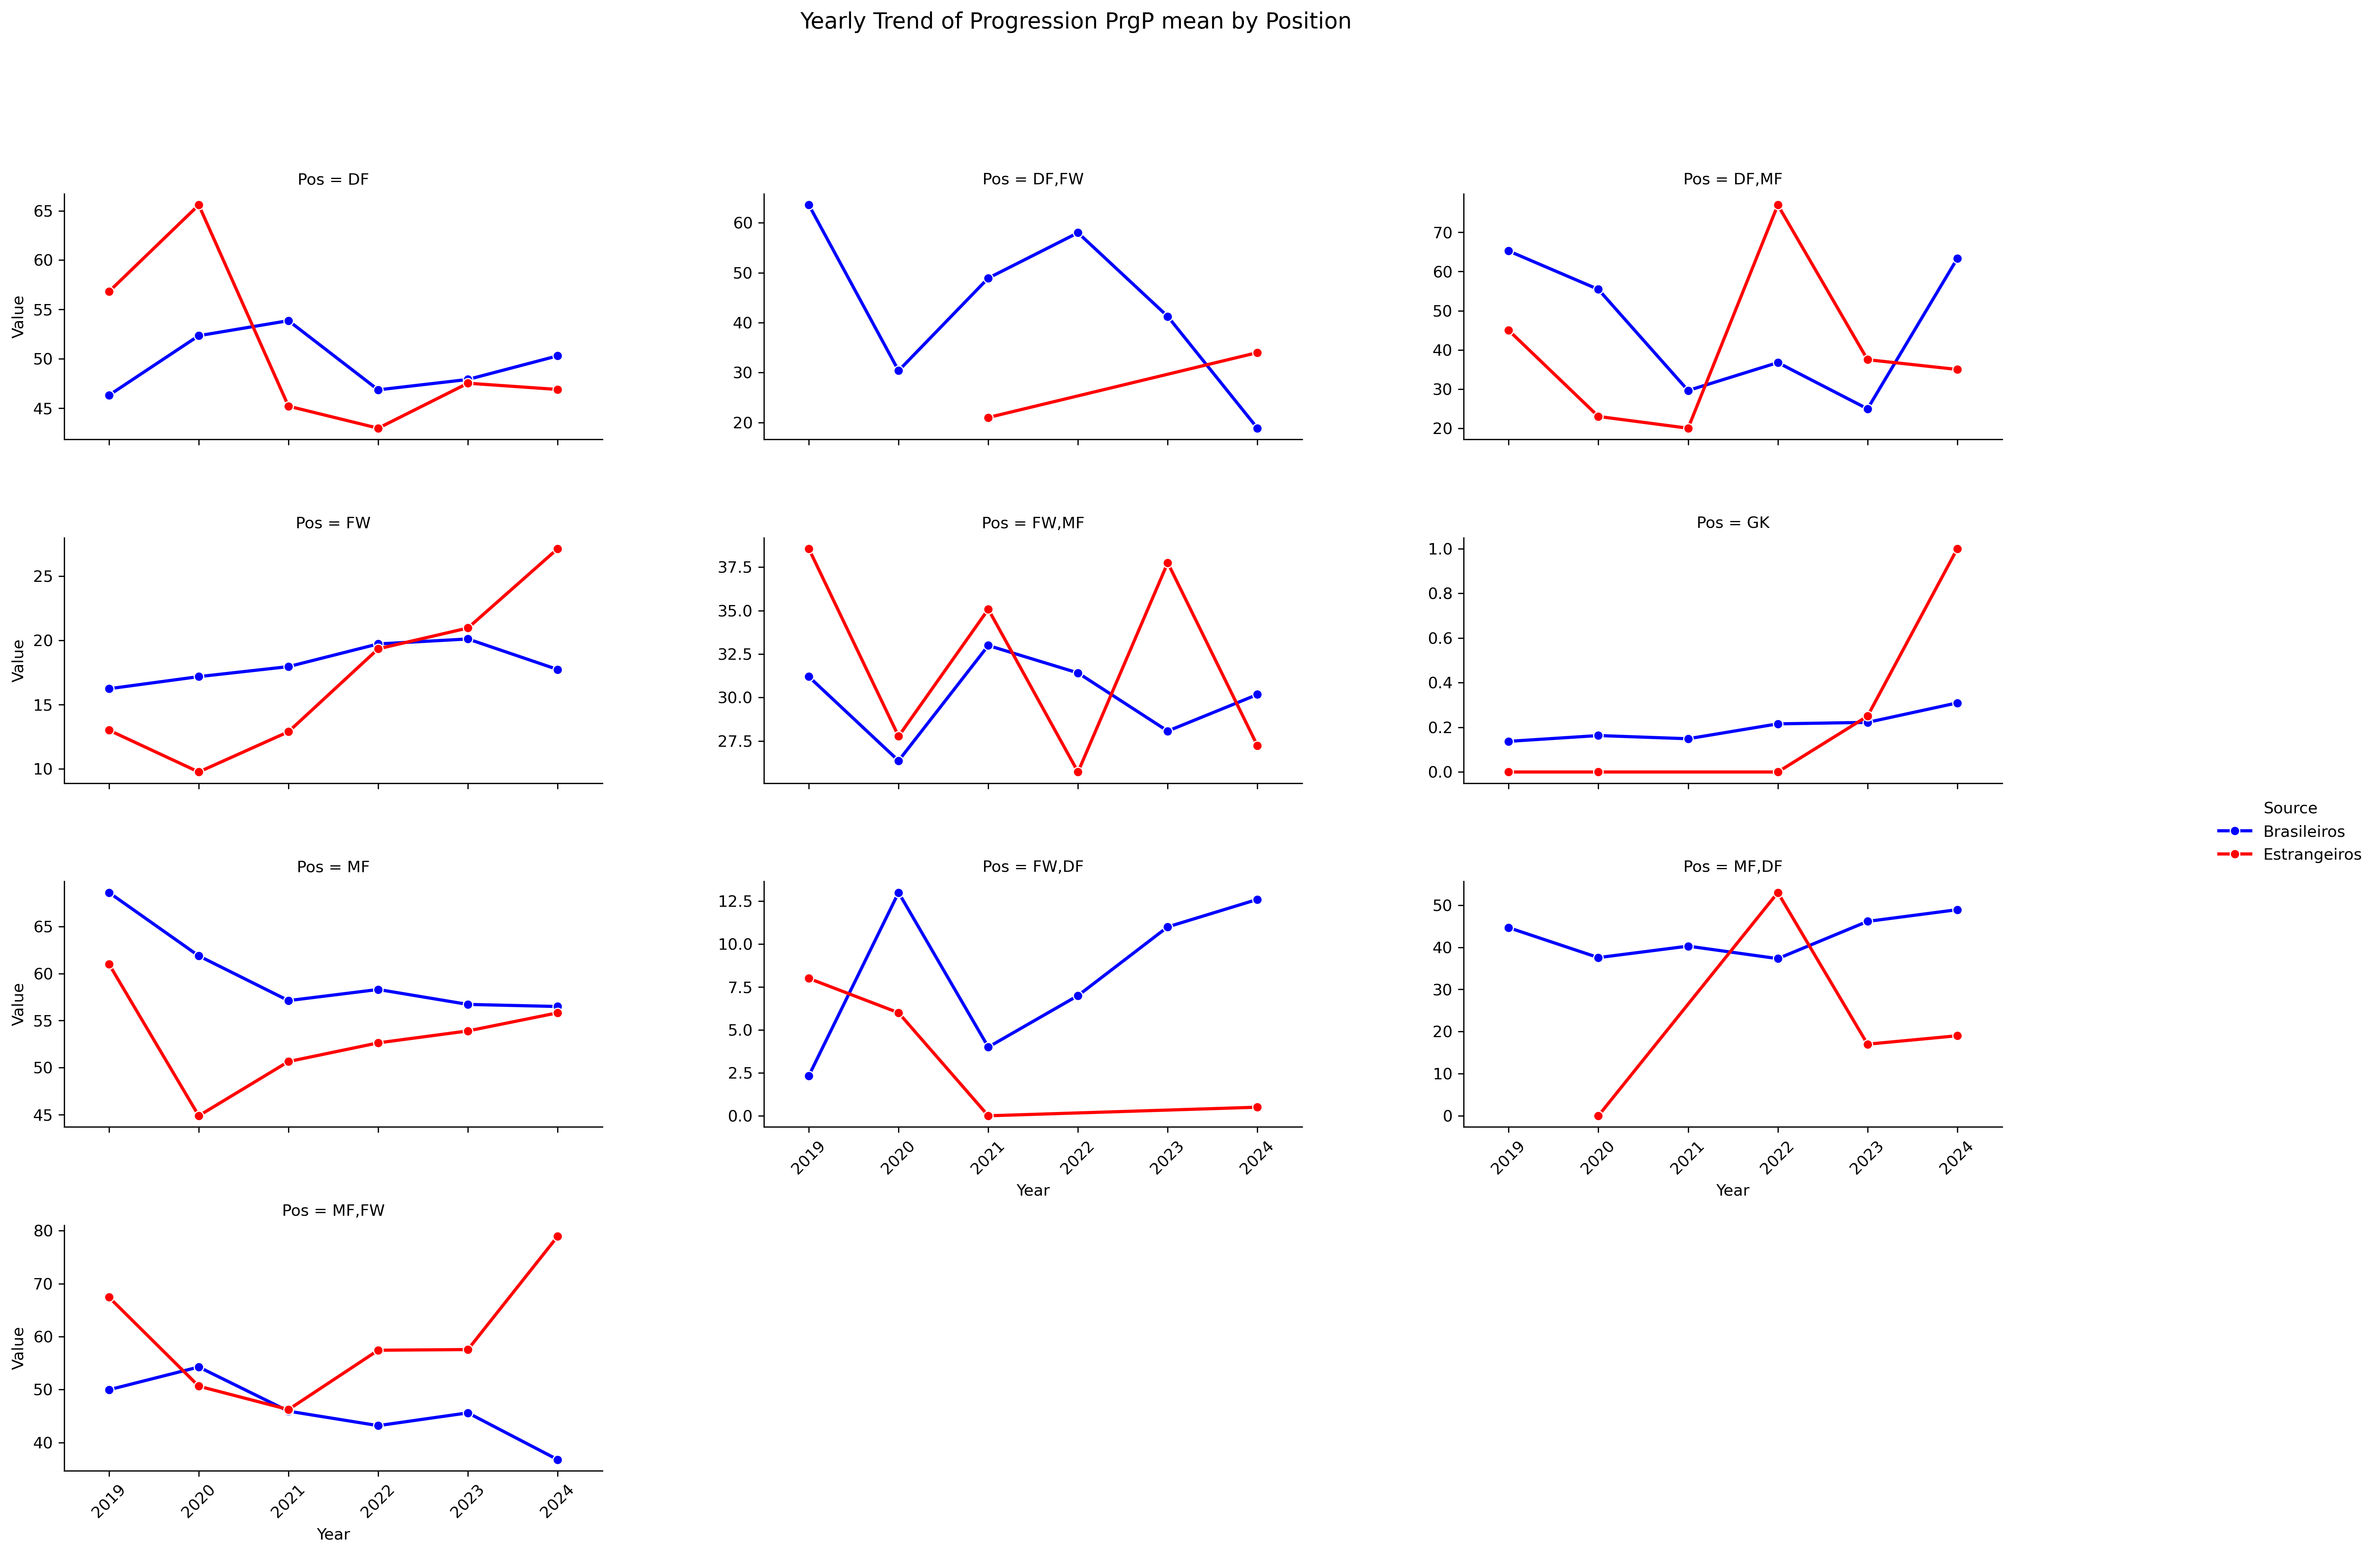

In [ ]:
Image("data/comparison_plots/by_pos/mean/Progression_PrgP_mean_by_position.png")

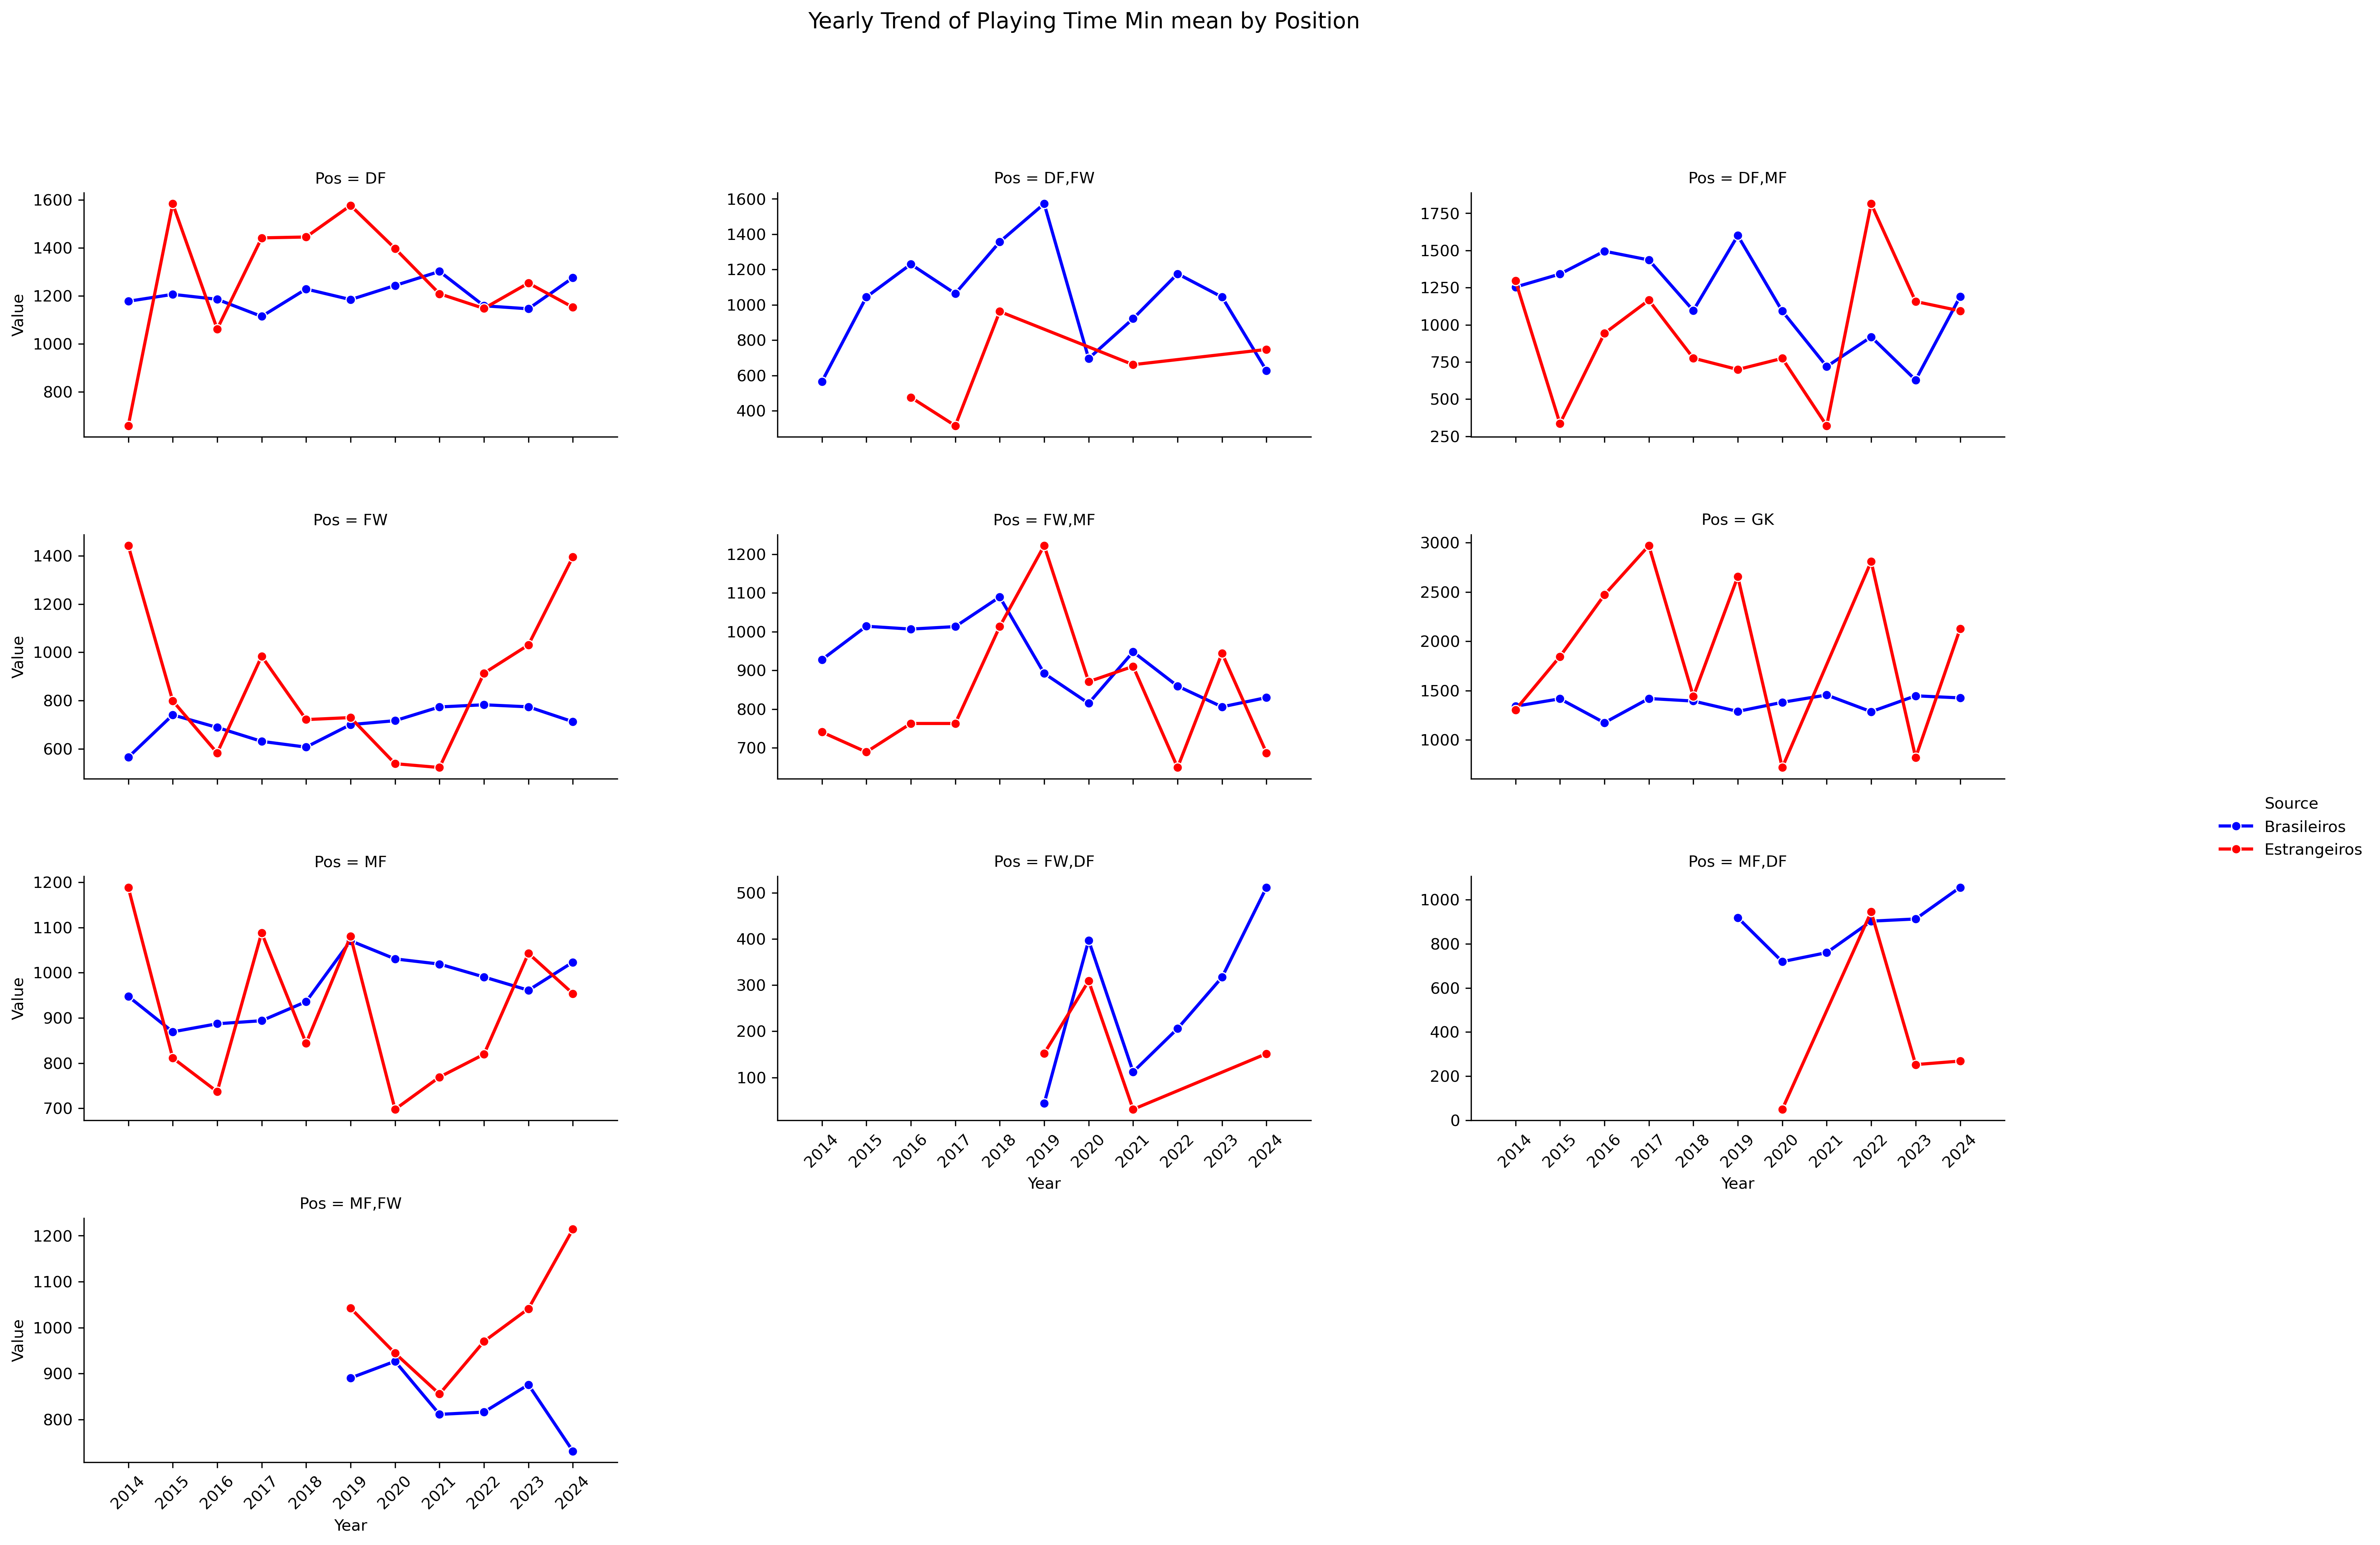

In [ ]:
Image("data/comparison_plots/by_pos/mean/Playing_Time_Min_mean_by_position.png")